# A simple practice of Logistic Regression
* Build a classification model
* Estimates an applicant's probability of admission based the scores from 2 exams
* Use sklearn logistic regression
    * Use F1-score
    * Use Grid search Cross Validation
    * Use threshold in hyper tuning

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
dir_data = '../../../../data/data_coursera_week2/ex2/ex2data1.txt'

In [3]:
df = pd.read_csv(dir_data, names=['score1', 'score2', 'admitted'])

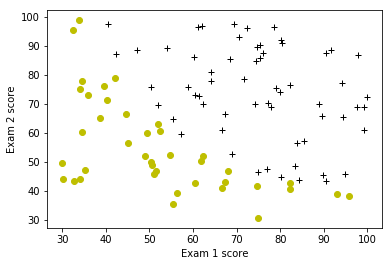

In [4]:
def plotData(df):
    x1 = df[df['admitted']==1]['score1']
    x2 = df[df['admitted']==0]['score1']
    y1 = df[df['admitted']==1]['score2']
    y2 = df[df['admitted']==0]['score2']    
    fig, ax = plt.subplots()
    ax.plot(x1,y1,"k+",x2,y2,"yo")
    ax.set_xlabel('Exam 1 score')
    ax.set_ylabel('Exam 2 score')
    return (fig, ax)

fig, ax = plotData(df)

# Use logistic regression model + F1-score
## model parameters
* penalty: l1 or l2 regularization constraints
* tol: Tolerance for stopping criteria
* C: Inverse of regularization strength
* class_weight: dict or 'balanced'
* random_state: int, the seed of random number generator to use when shuffling the data

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


X = df.loc[:, ['score1', 'score2']].values
y = df.loc[:, ['admitted']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

model = LogisticRegression(penalty='l2', tol=1e-4, C=1.0, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("F1-Score is %.5f" %f1_score(y_test, y_pred, average='binary'))

F1-Score is 0.89655


# Use logistic regression model + F1-Score + K-folder Cross Validation

Cross Validatin F1-Score is: 0.91878


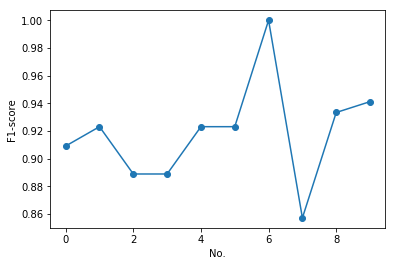

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

scores, iters = [], []
it = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression(penalty='l2', tol=1e-4, C=1.0, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='binary')
    scores.append(score)
    iters.append(it)
    it += 1

fig, ax = plt.subplots()
ax.plot(iters, scores, '-o')
ax.set_xlabel("No.")
ax.set_ylabel("F1-score")
score_avg = np.mean(scores)
print("Cross Validatin F1-Score is: %.5f" %score_avg)

# Use logistic regression model + F1-Score + K-folder Cross Validation + Grid Search

* Defined own estimator for logistic regression
* Use **F1-score** for evaluating result
* Set **threshold** as a new tuning parameter

In [146]:
from sklearn.linear_model import LogisticRegression

class logisticRegressionWithF1Score(LogisticRegression):
    def __init__(self, penalty='l2', dual=False, tol=1e-4, C=1.0,
                 fit_intercept=True, intercept_scaling=1, class_weight=None,
                 random_state=None, solver='liblinear', max_iter=100,
                 multi_class='ovr', verbose=0, warm_start=False, n_jobs=1,
                 threshold=0.5):
        self.threshold = threshold
        super().__init__(penalty='l2', dual=False, tol=1e-4, C=1.0,
                 fit_intercept=True, intercept_scaling=1, class_weight=None,
                 random_state=None, solver='liblinear', max_iter=100,
                 multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
    
    def predict(self, X): 
        probs = self.predict_proba(X)[:,1]
        probs[probs>=self.threshold] = 1
        probs[probs<self.threshold] = 0
        return probs
            
    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import f1_score
        y_pred = self.predict(X)
        score = f1_score(y, y_pred, average='binary', sample_weight=sample_weight)
        return score

 
from sklearn.grid_search import GridSearchCV
tuned_params = {'tol':[1e-3, 1e-4, 1e-5, 1e-6], 
                'penalty':['l1', 'l2'],
                'threshold': [0.05*x+0.2 for x in range(1,12)]}
gs = GridSearchCV(logisticRegressionWithF1Score(), tuned_params)
X = df.loc[:, ['score1', 'score2']].values
y = df.loc[:, ['admitted']].values.ravel()
gs.fit(X, y)
print("Best Score: %.5f" %gs.best_score_)
        

Best Score: 0.93667


In [147]:
grid_scores = gs.grid_scores_
iters, mean_scores, errs = [], [], []
for i in range(len(grid_scores)):
    iters.append(i)
    mean_scores.append(grid_scores[i].cv_validation_scores.mean())
    errs.append(grid_scores[i].cv_validation_scores.std())

Text(0,0.5,'F1-score')

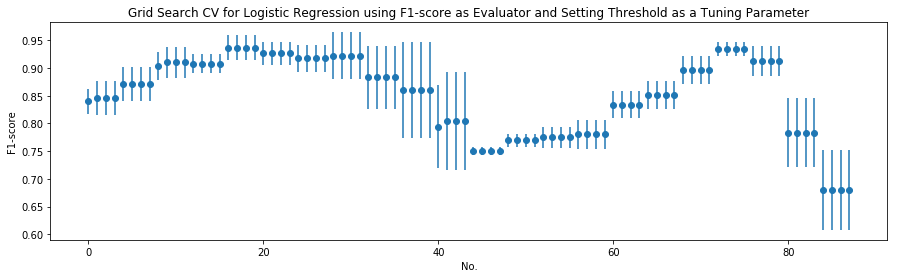

In [154]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15,4))
plt.errorbar(iters, mean_scores, errs, linestyle='None', marker='o')
ax.set_title("Grid Search CV for Logistic Regression using F1-score as Evaluator and Setting Threshold as a Tuning Parameter")
ax.set_xlabel("No.")
ax.set_ylabel("F1-score")